In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using CSV
using Dates
using Colors
using Plots
using Statistics
using MathOptInterface
using FileIO
using JLD2

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("Example-Markowitz-CodeLib.jl");

In [4]:
# load the JLD2 portfolio data file -
price_data_dictionary = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [5]:
# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

In [6]:
# compute the returns -
return_data_dictionary = Dict{String,DataFrame}();
for ticker_symbol ∈ ticker_symbol_array

    # Serenity -> computes the log return given a DataFrame, returns a DataFrame
    global return_data_dictionary[ticker_symbol] = compute_log_return_array(price_data_dictionary[ticker_symbol], 
        :timestamp => :close; Δt = (1.0 / 1.0))
end

In [7]:
# compute the cov -
Σ = compute_covariance_array(ticker_symbol_array, return_data_dictionary);
μ_vector = compute_mean_return_array(ticker_symbol_array, return_data_dictionary);

In [8]:
target_return_array = range(0.00001, step=0.0001, stop = 0.007) |> collect
L = length(target_return_array)
risk_array = Array{Float64,1}();
return_array = Array{Float64,1}();

for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, optval, ret_val) = compute_minvar_portfolio_allocation(μ_vector, Σ, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        push!(risk_array, optval)
        push!(return_array, ret_val)
    end
end

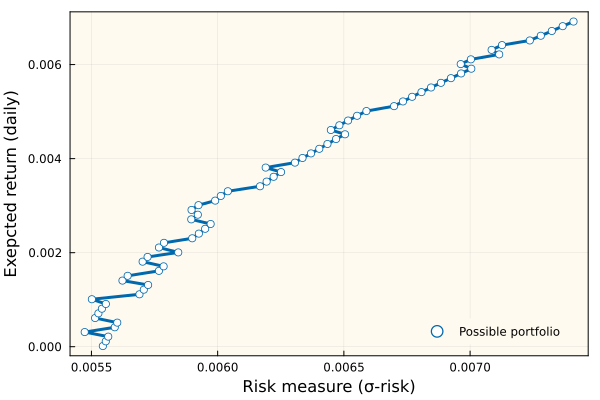

In [9]:
plot(sqrt.(0.1*risk_array), return_array, label="", c=colorant"#0068AC", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3)
scatter!(sqrt.(0.1*risk_array), return_array, label="Possible portfolio", mc=:white, msc=colorant"#0068AC")

xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted return (daily)", fontsize=18)